# PreProcessing

### Importing Necessary Libraries

In [1]:
import torch
import concurrent.futures
import pandas as pd
import requests
import numpy as np
import io
import random
import matplotlib.pyplot as plt
import ast
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

### Reading data and creating a dataframe

In [3]:
data = pd.read_csv('belt_data.csv')
data['labels'] = data['labels'].apply(lambda x: x.split(','))
mlb = MultiLabelBinarizer()
labels_encoded = mlb.fit_transform(data['labels'])
for i, label in enumerate(mlb.classes_):
    data[label] = labels_encoded[:, i]
data['image_url'] = data['image_url'].str.replace(' ', '')
data['labels_crops'] = data['labels_crops'].apply(
    lambda x: ast.literal_eval(x))
data.drop(columns=['labels'], inplace=True)

### Downloading the images

In [4]:
""" def download_image(url, file_name):
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        print('Downloading ' + file_name)
        r.raw.decode_content = True
        with open(file_name, 'wb') as f:
            f.write(r.content)
        return file_name
    else:
        return None

with concurrent.futures.ThreadPoolExecutor() as executor:
    for i, row in data.iterrows():
        file_name = 'images/' + str(i) + '.jpg'
        url = row['image_url']
        executor.submit(download_image, url, file_name) """

" def download_image(url, file_name):\n    r = requests.get(url, stream=True)\n    if r.status_code == 200:\n        print('Downloading ' + file_name)\n        r.raw.decode_content = True\n        with open(file_name, 'wb') as f:\n            f.write(r.content)\n        return file_name\n    else:\n        return None\n\nwith concurrent.futures.ThreadPoolExecutor() as executor:\n    for i, row in data.iterrows():\n        file_name = 'images/' + str(i) + '.jpg'\n        url = row['image_url']\n        executor.submit(download_image, url, file_name) "

### Cropping the Image

In [5]:
def preprocess_image(file, labels_crops):
    x1, y1, x2, y2 = int(labels_crops[0]), int(
        labels_crops[1]), int(labels_crops[2]), int(labels_crops[3])
    img = Image.open(file)
    img = img.crop((x1, y1, x2, y2))
    return img

with concurrent.futures.ThreadPoolExecutor(12) as executor:
    for i, row in data.iterrows():
        file_name = 'images/' + str(i) + '.jpg'
        labels_crops = row['labels_crops']
        data.at[i, 'image_data'] = executor.submit(
            preprocess_image, file_name, labels_crops)

data['image_data'] = data['image_data'].apply(lambda x: x.result())

### Dropping the URL and crops

In [6]:
data.drop(columns=['image_url'], inplace=True)
data.drop(columns=['labels_crops'], inplace=True)

### Visualization of Data

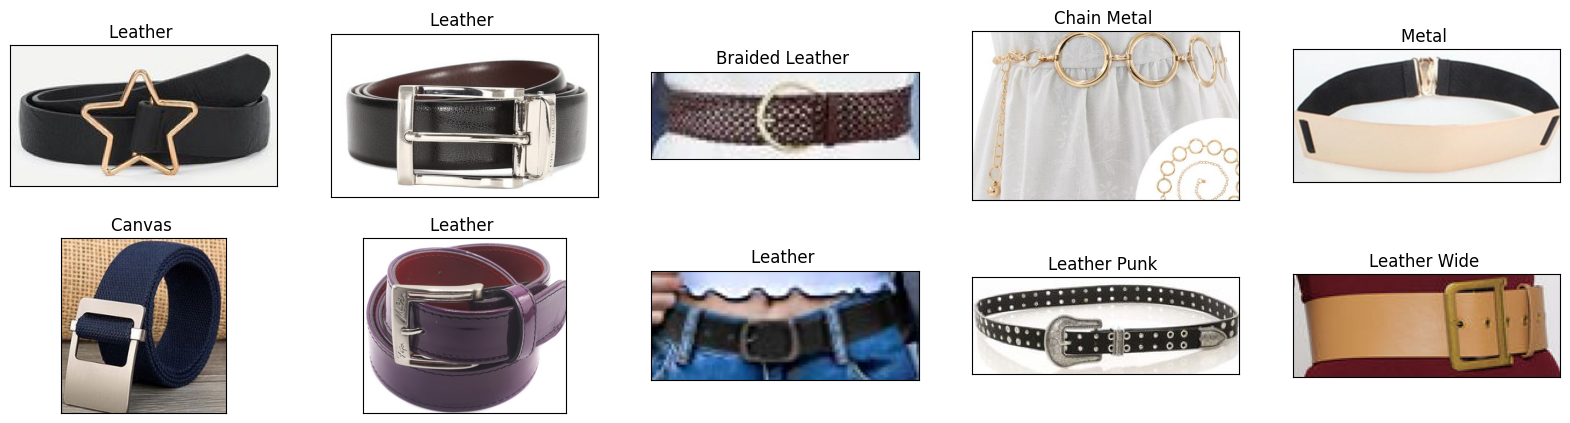

In [7]:
fig = plt.figure(figsize=(20, 5))
for i in range(10):
    index = random.randint(0, len(data))
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    title = ''
    for label in mlb.classes_:
        if data[label][index] == 1:
            title = title + label + ' '
    plt.imshow(data['image_data'][index])
    ax.set_title(title)

# Model Building

### Split the data into training (70%), validation (15%), and test (15%) sets

In [8]:
from sklearn.model_selection import train_test_split

train_data, temp_data = train_test_split(data, test_size=0.3, random_state=31)
valid_data, test_data = train_test_split(
    temp_data, test_size=0.5, random_state=31)


print("Training set size:", len(train_data))
print("Validation set size:", len(valid_data))
print("Test set size:", len(test_data))

Training set size: 3159
Validation set size: 677
Test set size: 677


### Belt Class

In [9]:
from torch.utils.data import Dataset, DataLoader


class BeltDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx]['image_data']
        labels = torch.tensor(
            self.data.iloc[idx][mlb.classes_], dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, labels

In [10]:
from sklearn.utils import resample
train_data_pos_list = []
train_data_neg_list = []

for label in mlb.classes_:
    train_data_pos_list.append(train_data[train_data[label] == 1])
    train_data_neg_list.append(train_data[train_data[label] == 0])

train_data_pos_resampled_list = []

for i in range(len(mlb.classes_)):
    train_data_pos_resampled_list.append(resample(
        train_data_pos_list[i], replace=True, n_samples=len(train_data_neg_list[i]), random_state=31))
    
train_data_resampled_list = []

for i in range(len(mlb.classes_)):
    train_data_resampled_list.append(pd.concat([train_data_pos_resampled_list[i], train_data_neg_list[i]]))


print("Training set size:", len(train_data_resampled_list[0]))
print("Validation set size:", len(valid_data))
print("Test set size:", len(test_data))


for i in range(len(mlb.classes_)):
    print(mlb.classes_[i])
    print("Positive examples: ", len(train_data_resampled_list[i][train_data_resampled_list[i][mlb.classes_[i]] == 1]))
    print("Negative examples: ", len(train_data_resampled_list[i][train_data_resampled_list[i][mlb.classes_[i]] == 0]))

Training set size: 5184
Validation set size: 677
Test set size: 677
Braided
Positive examples:  2592
Negative examples:  2592
Canvas
Positive examples:  2543
Negative examples:  2543
Chain
Positive examples:  2785
Negative examples:  2785
Leather
Positive examples:  1454
Negative examples:  1454
Metal
Positive examples:  2445
Negative examples:  2445
Misc
Positive examples:  2877
Negative examples:  2877
Punk
Positive examples:  2603
Negative examples:  2603
Wide
Positive examples:  2901
Negative examples:  2901


In [11]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])


train_set = BeltDataset(train_data_resampled_list[0], transform=train_transform)
valid_set = BeltDataset(valid_data, transform=valid_transform)
test_set = BeltDataset(test_data, transform=test_transform)

train_loader = DataLoader(train_set, batch_size=64,shuffle=True, num_workers=3)
valid_loader = DataLoader(valid_set, batch_size=64,
                          shuffle=True, num_workers=3)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True, num_workers=3)

In [12]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


class BeltClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv5_bn = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc1_bn = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 128)
        self.fc2_bn = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.fc3_bn = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 8)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(nn.functional.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool(nn.functional.relu(self.conv3_bn(self.conv3(x))))
        x = self.pool(nn.functional.relu(self.conv4_bn(self.conv4(x))))
        x = self.pool(nn.functional.relu(self.conv5_bn(self.conv5(x))))
        x = x.view(-1, 256*7*7)
        x = self.dropout(nn.functional.relu(self.fc1_bn(self.fc1(x))))
        x = self.dropout(nn.functional.relu(self.fc2_bn(self.fc2(x))))
        x = self.dropout(nn.functional.relu(self.fc3_bn(self.fc3(x))))
        x = self.fc4(x)
        return x

model = BeltClassifier()
print(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, verbose=True)

BeltClassifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_f

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BeltClassifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_f

In [14]:
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
output = model(images)
output = output.detach().cpu().numpy()
output = np.where(output > 0.5, 1, 0)
print(output[0])
print(labels[0].cpu().numpy())

[0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 1. 0. 0. 0.]


In [15]:
import warnings
warnings.filterwarnings('ignore')
epochs = 32
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

criterion.to(device)
model.to(device)
for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    train_correct = 0
    valid_correct = 0
    train_total = 0
    valid_total = 0

    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        output = output.detach().cpu().numpy()
        output = np.where(output > 0.5, 1, 0)
        train_total += labels.size(0) * labels.size(1)
        train_correct += np.sum(output == labels.cpu().numpy())

    model.eval()
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item() * images.size(0)
        output = output.detach().cpu().numpy()
        output = np.where(output > 0.5, 1, 0)
        valid_total += labels.size(0) * labels.size(1)
        valid_correct += np.sum(output == labels.cpu().numpy())

    train_accuracy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total
    train_losses.append(train_loss / len(train_loader.dataset))
    valid_losses.append(valid_loss / len(valid_loader.dataset))
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch + 1, train_loss / len(train_loader.dataset), valid_loss / len(valid_loader.dataset), train_accuracy*100, valid_accuracy*100))
    scheduler.step(valid_loss)

    writer.add_scalar('Loss/train', train_loss / len(train_loader.dataset), epoch)
    writer.add_scalar('Loss/valid', valid_loss / len(valid_loader.dataset), epoch)
    writer.add_scalar('Accuracy/train', train_accuracy, epoch)
    writer.add_scalar('Accuracy/valid', valid_accuracy, epoch)

Epoch: 1 	Training Loss: 0.445356 	Validation Loss: 0.370863 	Training Accuracy: 84.531732 	Validation Accuracy: 84.268833
Epoch: 2 	Training Loss: 0.284438 	Validation Loss: 0.406525 	Training Accuracy: 87.962963 	Validation Accuracy: 82.717873
Epoch: 3 	Training Loss: 0.249516 	Validation Loss: 0.434946 	Training Accuracy: 89.349441 	Validation Accuracy: 81.480798
Epoch: 4 	Training Loss: 0.224478 	Validation Loss: 0.267261 	Training Accuracy: 90.376640 	Validation Accuracy: 88.681684
Epoch: 5 	Training Loss: 0.205277 	Validation Loss: 0.303281 	Training Accuracy: 91.304977 	Validation Accuracy: 87.167651
Epoch: 6 	Training Loss: 0.187017 	Validation Loss: 0.268510 	Training Accuracy: 92.177855 	Validation Accuracy: 88.626292
Epoch: 7 	Training Loss: 0.169526 	Validation Loss: 0.263887 	Training Accuracy: 93.043499 	Validation Accuracy: 88.810931
Epoch: 8 	Training Loss: 0.157409 	Validation Loss: 0.302287 	Training Accuracy: 93.561921 	Validation Accuracy: 86.890694
Epoch: 9 	Traini

In [16]:
# save the model if accuracy has increased
#torch.save(model.state_dict(), 'belt_classifier.pt')
# load the model
#model.load_state_dict(torch.load('belt_classifier.pt'))

In [17]:
correct = 0
total = 0
model.eval()
model.to(device)
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    output = output.detach().cpu().numpy()
    output = np.where(output > 0.5, 1, 0)
    total += labels.size(0) * labels.size(1)
    correct += np.sum(output == labels.cpu().numpy())

print('Test Accuracy: {:.6f}'.format(100 * correct / total))

Test Accuracy: 92.688331


### Metrics for multi-label classification confusion matrix, precision, recall, f1-score

In [18]:
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_fscore_support

model.to(device)

y_true = []
y_pred = []
model.eval()
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    output = output.detach().cpu().numpy()
    output = np.where(output > 0.5, 1, 0)
    y_true.append(labels.cpu().numpy())
    y_pred.append(output)

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

confusion_matrix = multilabel_confusion_matrix(y_true, y_pred)
print(confusion_matrix)

precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted')
print('Precision: {:.6f}'.format(precision))
print('Recall: {:.6f}'.format(recall))
print('F1-score: {:.6f}'.format(f1))

[[[548  10]
  [ 26  93]]

 [[523  20]
  [ 29 105]]

 [[595  11]
  [ 23  48]]

 [[281  41]
  [ 58 297]]

 [[498  17]
  [ 49 113]]

 [[611   8]
  [ 22  36]]

 [[550  13]
  [ 30  84]]

 [[618   4]
  [ 35  20]]]
Precision: 0.863794
Recall: 0.745318
F1-score: 0.795888


### Prediction for an image

Predicted: ('Leather',)
Actual: ('Leather',)


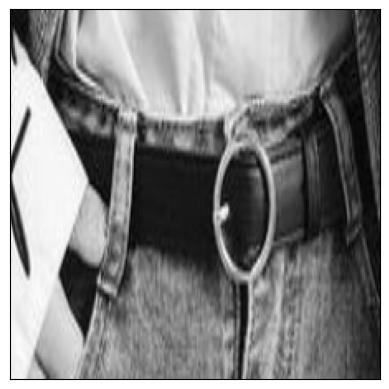

In [19]:
images, labels = next(iter(test_loader))
model.to('cpu')
output = model(images)
output = output.detach().numpy()
output = np.where(output > 0.5, 1, 0)
print('Predicted:', mlb.inverse_transform(output)[0])
print('Actual:', mlb.inverse_transform(labels.numpy())[0])
plt.imshow(images[0].squeeze(), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [20]:
writer.add_graph(model, images)
writer.add_embedding(output, metadata=mlb.inverse_transform(output))
writer.add_pr_curve('pr_curve', labels, output)

# Visualization:

### Loss vs Epochs & Accuracy vs Epochs

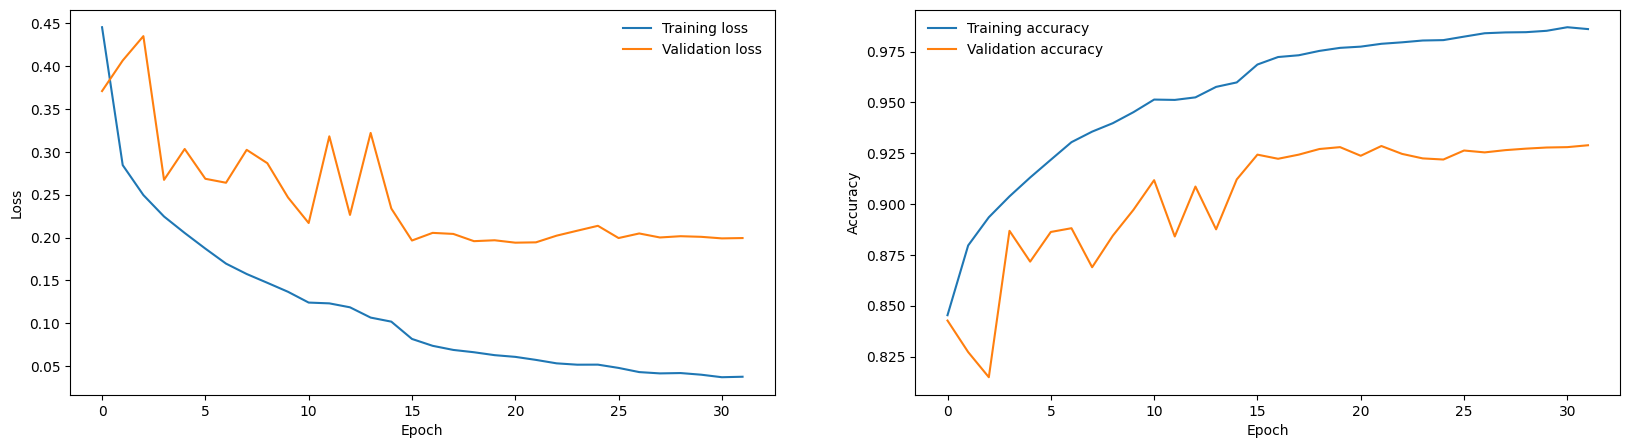

In [21]:
fig = plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(frameon=False)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(valid_accuracies, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(frameon=False)

# Add the plot to TensorBoard
plt.show()
writer.add_figure('loss', fig)

### Plot the confusion matrix

### Plotting using seaborn

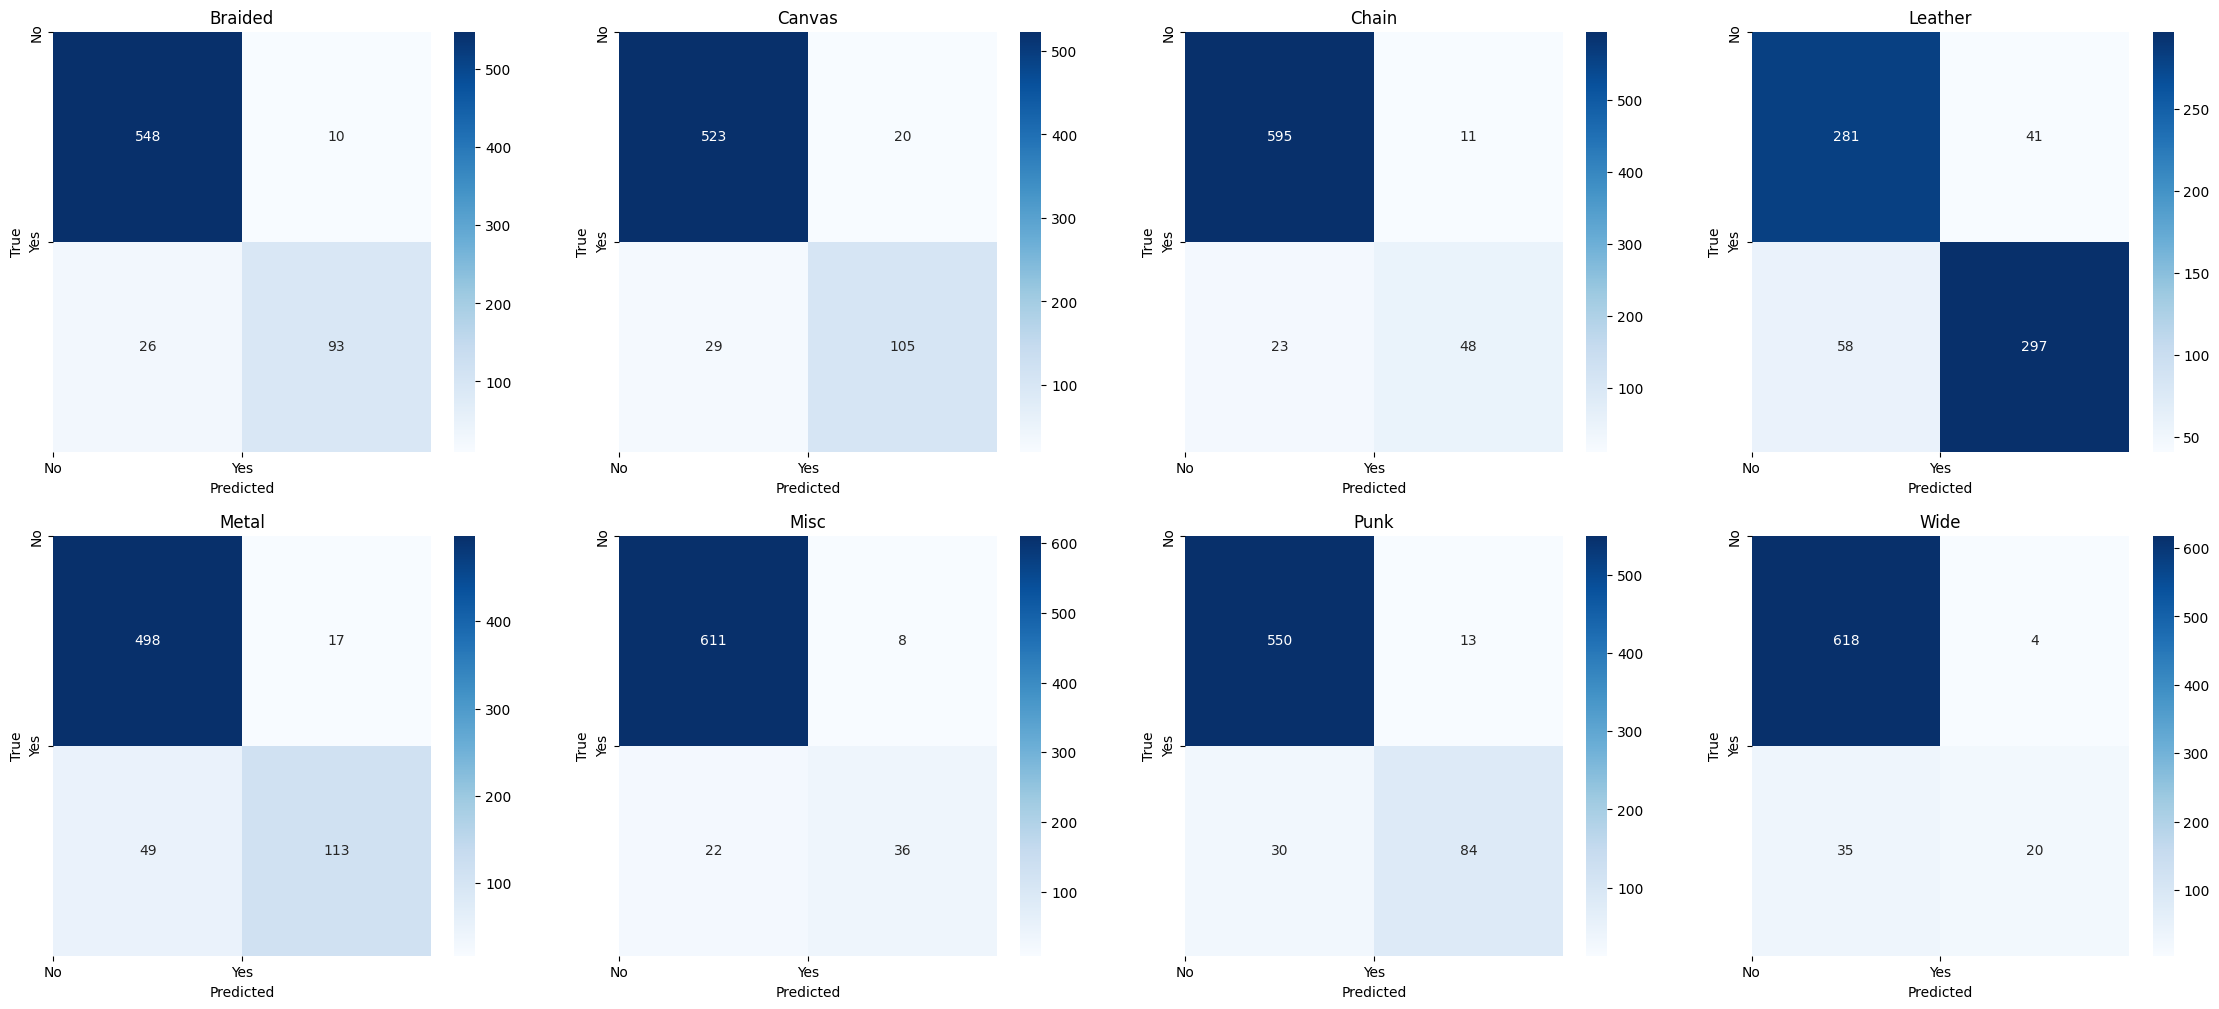

In [22]:
#plot the confusion matrix using seaborn in a loop 4 in a row
import seaborn as sns
fig = plt.figure(figsize=(28, 12))
for i in range(len(mlb.classes_)):
    ax = fig.add_subplot(2, 4, i + 1)
    sns.heatmap(confusion_matrix[i], annot=True, fmt='d', cmap=plt.cm.Blues, cbar=True)
    plt.title(mlb.classes_[i])
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No', 'Yes'])
    plt.yticks(tick_marks, ['No', 'Yes'])
    plt.ylabel('True')
    plt.xlabel('Predicted')

plt.show()
writer.add_figure('confusion_matrix', fig)

In [23]:
writer.close()